# 1. Build your own convolutional neural network using pytorch

In [1]:
import os
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import sys
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
os.listdir('./')

['.config', 'drive', 'ep_2.pt', 'CNN_test_new1.csv', 'sample_data']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
!nvidia-smi

Fri Nov 11 22:11:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
train_data_path = '/content/drive/MyDrive/Colab Notebooks/Project 1-CV/Datasets/Train'

In [7]:
test_data_path = '/content/drive/MyDrive/Colab Notebooks/Project 1-CV/Datasets/Test'

In [8]:
# resize the images in transforms
training_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:

total_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = training_transform)
train_size = int(len(total_data) * 0.85) # 85% training data
valid_size = len(total_data) - train_size # 15% validation data

In [10]:
# train_data, valid_data = data.random_split(train_data, [train_size, valid_size])

In [11]:
# import random

# random.shuffle(train_data)

# train_data = data[:int((len(train_data)+1)*.80)] 
# valid_data = data[int((len(train_data)+1)*.80):] 

In [12]:
# train_data, valid_data = data.random_split(train_data, [train_size, valid_size])
# train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle = True)
# valid_loader = torch.utils.data.DataLoader(dataset = valid_data, batch_size=32, shuffle = True)

In [13]:
from re import I
# CNN Network
class ConvNet(nn.Module):
  def __init__(self, num_classes = 4):
    super(ConvNet, self).__init__()
    # 3, 224, 224
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    # 16, 224, 224
    self.pool1 =  nn.MaxPool2d(2)
    # 16, 112, 112
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 0),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    # 32, 110, 110
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 0),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    # 64, 108, 108
    self.pool2 = nn.MaxPool2d(2)
    # 64, 54, 54

    self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 2, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU())
    # 128, 28, 28
    self.layer5 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size = 2, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU())
    # 128, 15, 15
    self.layer6 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 0),
        nn.BatchNorm2d(256),
        nn.ReLU())
    # 256, 7, 7
    self.layer7 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size = 3, stride = 2, padding = 0),
        nn.BatchNorm2d(256),
        nn.ReLU())
    # 256, 3, 3

    self.fc1 = nn.Linear(in_features = 256*3*3, out_features = 1028)
    # self.dropout = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 1028, out_features = num_classes)

    # feed forward function
  def forward(self, input):
    out = self.pool1(self.layer1(input))
    out = self.pool2(self.layer3(self.layer2(out)))
    out = self.layer7(self.layer6(self.layer5(self.layer4(out))))
    out = out.view(-1, 256*3*3)
    out = F.relu(self.fc1(out))
    # out = self.dropout(out)
    out = F.relu(self.fc2(out))
    return out

In [14]:
model = ConvNet(num_classes = 4).to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequen

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

In [15]:
# Use an "Adam" optimizer to adjust weights
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()
LR = 0.0001

In [16]:
import tqdm
import torch
classes = ('1', '2', '3', '4')

In [17]:
epochs = 150
x = []
t_loss = []
v_loss = []
t_acc =  []
v_acc = []
for epoch in range(epochs):
    print(f"Epoch{epoch +1} of {epochs}")
    import torch.utils.data as data
    # the sample number is only 1149, so choose to randam shuffle the dataset every time by 85% and 15% ratio
    train_data, valid_data = data.random_split(total_data, [train_size, valid_size])
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle = True)
    valid_loader = torch.utils.data.DataLoader(dataset = valid_data, batch_size=32, shuffle = True)   

    # Training set
    model.train() 
    train_loss = 0.0
    # train_acc = 0.0
    valid_loss = 0.0
    # valid_acc = 0.0
    t_correct = 0
    t_total = 0
    v_correct = 0
    v_total = 0
    t_correct_pred = {classname: 0 for classname in classes}
    t_total_pred = {classname: 0 for classname in classes}
    v_correct_pred = {classname: 0 for classname in classes}
    v_total_pred = {classname: 0 for classname in classes}
    for bi, data in tqdm.tqdm(enumerate(train_loader), total = len(train_loader)):
        images = data[0].to(device)
        label = data[1].to(device)
        out = model(images)
        loss = loss_criteria(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ret, predictions = torch.max(out.data, 1)
        # calculate total accuracy
        t_total += label.size(0)
        t_correct += (predictions == label).sum().item()

        # calculate per class accuracy
        for label, predictions in zip(label, predictions):
          if label == predictions:
            t_correct_pred[classes[label]] += 1
          t_total_pred[classes[label]] +=1

    else:
      # print accuracy and loss
        print(f"Training loss: {train_loss/len(train_loader)}") 
        print(f"Training Accuracy: {100 * t_correct // t_total}")
        # print accuracy per class
        for classname, correct_count in t_correct_pred.items():
          if t_total_pred[classname] != 0:
            accuracy = 100 * float(correct_count) / t_total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
          else:
            print(f'Accuracy for class: {classname:5s} is 0')
    #save loss and accuracy in lists
    t_loss.append(train_loss/len(train_loader))
    t_acc.append(100 * t_correct // t_total)
    
    # Testing set
    model.eval()
    with torch.no_grad():
        for bi, data in tqdm.tqdm(enumerate(valid_loader), total = len(valid_loader)):
            images = data[0].to(device)
            label = data[1].to(device)
            out = model(images)
            loss = loss_criteria(out, label)
            valid_loss += loss.item()
            ret, predictions = torch.max(out.data, 1)
            # calculate total accuracy
            v_total += label.size(0)
            v_correct += (predictions == label).sum().item()


           # calculate per class accuracy
            for label, predictions in zip(label, predictions):
              if label == predictions:
                v_correct_pred[classes[label]] += 1
              v_total_pred[classes[label]] +=1
 
        else:
          # print accuracy and loss
          print(f"Validation loss: {valid_loss/len(valid_loader)}") 
          print(f"Validation Accuracy: {100 * v_correct // v_total}")
          # print accuracy per class
          for classname, correct_count in v_correct_pred.items():
            if v_total_pred[classname] != 0:
              accuracy = 100 * float(correct_count) / v_total_pred[classname]
              print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
            else:
              print(f'Accuracy for class: {classname:5s} is 0')
    #save loss and accuracy in lists
        v_loss.append(valid_loss/len(valid_loader))
        v_acc.append(100 * v_correct // v_total)

print("Learning Finished")
torch.save(model, 'ep_2.pt')

Epoch1 of 150


100%|██████████| 31/31 [00:22<00:00,  1.39it/s]


Training loss: 1.057717986645237
Training Accuracy: 54
Accuracy for class: 1     is 56.9 %
Accuracy for class: 2     is 73.6 %
Accuracy for class: 3     is 2.6 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Validation loss: 1.0787822206815083
Validation Accuracy: 50
Accuracy for class: 1     is 41.8 %
Accuracy for class: 2     is 89.6 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch2 of 150


100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Training loss: 0.9753046228039649
Training Accuracy: 57
Accuracy for class: 1     is 73.0 %
Accuracy for class: 2     is 61.3 %
Accuracy for class: 3     is 17.0 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Validation loss: 0.9362383484840393
Validation Accuracy: 64
Accuracy for class: 1     is 86.1 %
Accuracy for class: 2     is 62.8 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch3 of 150


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Training loss: 0.9481146258692588
Training Accuracy: 58
Accuracy for class: 1     is 71.7 %
Accuracy for class: 2     is 67.7 %
Accuracy for class: 3     is 7.0 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Validation loss: 1.0372185707092285
Validation Accuracy: 55
Accuracy for class: 1     is 80.9 %
Accuracy for class: 2     is 56.2 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch4 of 150


100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Training loss: 0.9520045941875827
Training Accuracy: 58
Accuracy for class: 1     is 74.7 %
Accuracy for class: 2     is 68.5 %
Accuracy for class: 3     is 5.5 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


Validation loss: 0.8898000121116638
Validation Accuracy: 64
Accuracy for class: 1     is 77.0 %
Accuracy for class: 2     is 68.0 %
Accuracy for class: 3     is 18.2 %
Accuracy for class: 4     is 0.0 %
Epoch5 of 150


100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Training loss: 0.8928039381580968
Training Accuracy: 63
Accuracy for class: 1     is 81.3 %
Accuracy for class: 2     is 64.8 %
Accuracy for class: 3     is 23.2 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.9444470306237539
Validation Accuracy: 46
Accuracy for class: 1     is 56.9 %
Accuracy for class: 2     is 60.3 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch6 of 150


100%|██████████| 31/31 [00:11<00:00,  2.73it/s]


Training loss: 0.8571805454069569
Training Accuracy: 62
Accuracy for class: 1     is 78.5 %
Accuracy for class: 2     is 63.4 %
Accuracy for class: 3     is 28.8 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Validation loss: 0.9391983350118002
Validation Accuracy: 58
Accuracy for class: 1     is 81.2 %
Accuracy for class: 2     is 51.3 %
Accuracy for class: 3     is 41.7 %
Accuracy for class: 4     is 0.0 %
Epoch7 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.8578240717611005
Training Accuracy: 62
Accuracy for class: 1     is 80.7 %
Accuracy for class: 2     is 62.3 %
Accuracy for class: 3     is 26.1 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


Validation loss: 0.8922793467839559
Validation Accuracy: 61
Accuracy for class: 1     is 87.9 %
Accuracy for class: 2     is 65.3 %
Accuracy for class: 3     is 6.7 %
Accuracy for class: 4     is 0.0 %
Epoch8 of 150


100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Training loss: 0.8913950804741152
Training Accuracy: 60
Accuracy for class: 1     is 74.8 %
Accuracy for class: 2     is 68.2 %
Accuracy for class: 3     is 12.8 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Validation loss: 1.0026906232039134
Validation Accuracy: 56
Accuracy for class: 1     is 58.0 %
Accuracy for class: 2     is 81.4 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch9 of 150


100%|██████████| 31/31 [00:11<00:00,  2.63it/s]


Training loss: 0.8420401350144417
Training Accuracy: 62
Accuracy for class: 1     is 81.2 %
Accuracy for class: 2     is 64.0 %
Accuracy for class: 3     is 20.0 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.8359819153944651
Validation Accuracy: 61
Accuracy for class: 1     is 89.4 %
Accuracy for class: 2     is 50.0 %
Accuracy for class: 3     is 31.2 %
Accuracy for class: 4     is 0.0 %
Epoch10 of 150


100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


Training loss: 0.8275318895616839
Training Accuracy: 65
Accuracy for class: 1     is 85.2 %
Accuracy for class: 2     is 65.2 %
Accuracy for class: 3     is 22.8 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Validation loss: 0.7618490358193716
Validation Accuracy: 61
Accuracy for class: 1     is 82.5 %
Accuracy for class: 2     is 65.1 %
Accuracy for class: 3     is 17.2 %
Accuracy for class: 4     is 0.0 %
Epoch11 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.8169900159681996
Training Accuracy: 65
Accuracy for class: 1     is 82.7 %
Accuracy for class: 2     is 64.8 %
Accuracy for class: 3     is 31.6 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.8818224867184957
Validation Accuracy: 63
Accuracy for class: 1     is 85.3 %
Accuracy for class: 2     is 69.9 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch12 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.8354163304451974
Training Accuracy: 62
Accuracy for class: 1     is 74.1 %
Accuracy for class: 2     is 65.4 %
Accuracy for class: 3     is 32.3 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Validation loss: 0.925369401772817
Validation Accuracy: 59
Accuracy for class: 1     is 90.0 %
Accuracy for class: 2     is 58.0 %
Accuracy for class: 3     is 6.9 %
Accuracy for class: 4     is 0.0 %
Epoch13 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.7812173770320031
Training Accuracy: 66
Accuracy for class: 1     is 84.5 %
Accuracy for class: 2     is 67.2 %
Accuracy for class: 3     is 27.8 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Validation loss: 0.914394478003184
Validation Accuracy: 58
Accuracy for class: 1     is 93.8 %
Accuracy for class: 2     is 36.6 %
Accuracy for class: 3     is 44.0 %
Accuracy for class: 4     is 0.0 %
Epoch14 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.8177892181181139
Training Accuracy: 64
Accuracy for class: 1     is 80.8 %
Accuracy for class: 2     is 60.1 %
Accuracy for class: 3     is 46.7 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Validation loss: 0.7477952738602957
Validation Accuracy: 68
Accuracy for class: 1     is 87.1 %
Accuracy for class: 2     is 69.5 %
Accuracy for class: 3     is 5.6 %
Accuracy for class: 4     is 0.0 %
Epoch15 of 150


100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Training loss: 0.7541826617333197
Training Accuracy: 65
Accuracy for class: 1     is 80.9 %
Accuracy for class: 2     is 67.9 %
Accuracy for class: 3     is 28.0 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Validation loss: 0.7711323300997416
Validation Accuracy: 65
Accuracy for class: 1     is 79.4 %
Accuracy for class: 2     is 64.2 %
Accuracy for class: 3     is 45.9 %
Accuracy for class: 4     is 0.0 %
Epoch16 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.7199317716783092
Training Accuracy: 68
Accuracy for class: 1     is 83.0 %
Accuracy for class: 2     is 63.4 %
Accuracy for class: 3     is 51.6 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Validation loss: 0.8411412437756857
Validation Accuracy: 63
Accuracy for class: 1     is 74.2 %
Accuracy for class: 2     is 60.3 %
Accuracy for class: 3     is 57.1 %
Accuracy for class: 4     is 0.0 %
Epoch17 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.7636943863284203
Training Accuracy: 65
Accuracy for class: 1     is 79.8 %
Accuracy for class: 2     is 66.3 %
Accuracy for class: 3     is 37.8 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.6112257540225983
Validation Accuracy: 68
Accuracy for class: 1     is 95.3 %
Accuracy for class: 2     is 67.1 %
Accuracy for class: 3     is 22.6 %
Accuracy for class: 4     is 0.0 %
Epoch18 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.7095987296873524
Training Accuracy: 69
Accuracy for class: 1     is 81.9 %
Accuracy for class: 2     is 70.8 %
Accuracy for class: 3     is 45.1 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Validation loss: 0.7165317634741465
Validation Accuracy: 66
Accuracy for class: 1     is 79.4 %
Accuracy for class: 2     is 72.5 %
Accuracy for class: 3     is 28.0 %
Accuracy for class: 4     is 0.0 %
Epoch19 of 150


100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


Training loss: 0.6935608781153156
Training Accuracy: 70
Accuracy for class: 1     is 83.6 %
Accuracy for class: 2     is 68.4 %
Accuracy for class: 3     is 49.1 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


Validation loss: 1.0495707591374714
Validation Accuracy: 52
Accuracy for class: 1     is 90.0 %
Accuracy for class: 2     is 44.6 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 0.0 %
Epoch20 of 150


100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


Training loss: 0.6678757907882813
Training Accuracy: 69
Accuracy for class: 1     is 80.6 %
Accuracy for class: 2     is 68.5 %
Accuracy for class: 3     is 54.0 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Validation loss: 0.6720767716566721
Validation Accuracy: 69
Accuracy for class: 1     is 82.3 %
Accuracy for class: 2     is 63.1 %
Accuracy for class: 3     is 57.7 %
Accuracy for class: 4     is 0.0 %
Epoch21 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.6870601907853158
Training Accuracy: 69
Accuracy for class: 1     is 80.0 %
Accuracy for class: 2     is 70.5 %
Accuracy for class: 3     is 52.1 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


Validation loss: 0.6390346686045328
Validation Accuracy: 73
Accuracy for class: 1     is 85.7 %
Accuracy for class: 2     is 75.3 %
Accuracy for class: 3     is 30.0 %
Accuracy for class: 4     is 0.0 %
Epoch22 of 150


100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Training loss: 0.638813312976591
Training Accuracy: 72
Accuracy for class: 1     is 85.0 %
Accuracy for class: 2     is 72.7 %
Accuracy for class: 3     is 52.5 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Validation loss: 0.7605660061041514
Validation Accuracy: 71
Accuracy for class: 1     is 92.8 %
Accuracy for class: 2     is 66.2 %
Accuracy for class: 3     is 32.0 %
Accuracy for class: 4     is 0.0 %
Epoch23 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.6442885706501622
Training Accuracy: 71
Accuracy for class: 1     is 80.5 %
Accuracy for class: 2     is 71.4 %
Accuracy for class: 3     is 58.3 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


Validation loss: 0.5281430135170618
Validation Accuracy: 78
Accuracy for class: 1     is 81.3 %
Accuracy for class: 2     is 86.1 %
Accuracy for class: 3     is 54.2 %
Accuracy for class: 4     is 0.0 %
Epoch24 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.6571256864455438
Training Accuracy: 69
Accuracy for class: 1     is 77.0 %
Accuracy for class: 2     is 67.6 %
Accuracy for class: 3     is 66.3 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


Validation loss: 0.6681587348381678
Validation Accuracy: 75
Accuracy for class: 1     is 92.6 %
Accuracy for class: 2     is 61.9 %
Accuracy for class: 3     is 83.3 %
Accuracy for class: 4     is 0.0 %
Epoch25 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.634611617172918
Training Accuracy: 72
Accuracy for class: 1     is 84.5 %
Accuracy for class: 2     is 72.4 %
Accuracy for class: 3     is 55.6 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Validation loss: 0.5272389153639475
Validation Accuracy: 73
Accuracy for class: 1     is 72.0 %
Accuracy for class: 2     is 85.9 %
Accuracy for class: 3     is 52.0 %
Accuracy for class: 4     is 0.0 %
Epoch26 of 150


100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


Training loss: 0.5312686360651447
Training Accuracy: 76
Accuracy for class: 1     is 83.9 %
Accuracy for class: 2     is 77.0 %
Accuracy for class: 3     is 66.2 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


Validation loss: 0.574097752571106
Validation Accuracy: 75
Accuracy for class: 1     is 86.4 %
Accuracy for class: 2     is 78.3 %
Accuracy for class: 3     is 60.6 %
Accuracy for class: 4     is 0.0 %
Epoch27 of 150


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Training loss: 0.5523754127563969
Training Accuracy: 76
Accuracy for class: 1     is 85.9 %
Accuracy for class: 2     is 75.9 %
Accuracy for class: 3     is 67.3 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Validation loss: 0.5329635143280029
Validation Accuracy: 75
Accuracy for class: 1     is 85.0 %
Accuracy for class: 2     is 77.4 %
Accuracy for class: 3     is 50.0 %
Accuracy for class: 4     is 0.0 %
Epoch28 of 150


100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Training loss: 0.5987329704146231
Training Accuracy: 74
Accuracy for class: 1     is 81.2 %
Accuracy for class: 2     is 74.6 %
Accuracy for class: 3     is 68.9 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Validation loss: 0.673297181725502
Validation Accuracy: 72
Accuracy for class: 1     is 74.2 %
Accuracy for class: 2     is 78.2 %
Accuracy for class: 3     is 57.7 %
Accuracy for class: 4     is 0.0 %
Epoch29 of 150


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Training loss: 0.5211939206046443
Training Accuracy: 77
Accuracy for class: 1     is 85.2 %
Accuracy for class: 2     is 78.5 %
Accuracy for class: 3     is 67.1 %
Accuracy for class: 4     is 0.0 %


100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


Validation loss: 0.5049293984969457
Validation Accuracy: 79
Accuracy for class: 1     is 85.9 %
Accuracy for class: 2     is 79.2 %
Accuracy for class: 3     is 65.0 %
Accuracy for class: 4     is 0.0 %
Epoch30 of 150


100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Training loss: 0.4696992770318062
Training Accuracy: 81
Accuracy for class: 1     is 86.4 %
Accuracy for class: 2     is 80.4 %
Accuracy for class: 3     is 78.8 %
Accuracy for class: 4     is 15.0 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.5745229224363962
Validation Accuracy: 76
Accuracy for class: 1     is 91.2 %
Accuracy for class: 2     is 79.2 %
Accuracy for class: 3     is 37.0 %
Accuracy for class: 4     is 0.0 %
Epoch31 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.5455441128823065
Training Accuracy: 77
Accuracy for class: 1     is 84.0 %
Accuracy for class: 2     is 79.3 %
Accuracy for class: 3     is 62.7 %
Accuracy for class: 4     is 29.4 %


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Validation loss: 0.5888789792855581
Validation Accuracy: 74
Accuracy for class: 1     is 83.8 %
Accuracy for class: 2     is 84.0 %
Accuracy for class: 3     is 34.6 %
Accuracy for class: 4     is 0.0 %
Epoch32 of 150


100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


Training loss: 0.4806010338567918
Training Accuracy: 81
Accuracy for class: 1     is 86.9 %
Accuracy for class: 2     is 82.5 %
Accuracy for class: 3     is 70.5 %
Accuracy for class: 4     is 42.1 %


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Validation loss: 0.3829932858546575
Validation Accuracy: 86
Accuracy for class: 1     is 93.3 %
Accuracy for class: 2     is 92.5 %
Accuracy for class: 3     is 64.5 %
Accuracy for class: 4     is 0.0 %
Epoch33 of 150


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Training loss: 0.43684027752568644
Training Accuracy: 81
Accuracy for class: 1     is 86.4 %
Accuracy for class: 2     is 80.6 %
Accuracy for class: 3     is 75.8 %
Accuracy for class: 4     is 44.4 %


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Validation loss: 0.35782388349374133
Validation Accuracy: 87
Accuracy for class: 1     is 86.5 %
Accuracy for class: 2     is 94.6 %
Accuracy for class: 3     is 68.2 %
Accuracy for class: 4     is 66.7 %
Epoch34 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.43511996346135295
Training Accuracy: 81
Accuracy for class: 1     is 85.2 %
Accuracy for class: 2     is 81.9 %
Accuracy for class: 3     is 75.9 %
Accuracy for class: 4     is 55.6 %


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Validation loss: 0.42356980343659717
Validation Accuracy: 79
Accuracy for class: 1     is 91.7 %
Accuracy for class: 2     is 71.4 %
Accuracy for class: 3     is 71.4 %
Accuracy for class: 4     is 33.3 %
Epoch35 of 150


100%|██████████| 31/31 [00:11<00:00,  2.58it/s]


Training loss: 0.4477360743668772
Training Accuracy: 81
Accuracy for class: 1     is 86.6 %
Accuracy for class: 2     is 81.4 %
Accuracy for class: 3     is 72.0 %
Accuracy for class: 4     is 36.8 %


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Validation loss: 0.39024311552445096
Validation Accuracy: 85
Accuracy for class: 1     is 91.3 %
Accuracy for class: 2     is 82.9 %
Accuracy for class: 3     is 84.6 %
Accuracy for class: 4     is 0.0 %
Epoch36 of 150


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Training loss: 0.47879719493850587
Training Accuracy: 81
Accuracy for class: 1     is 88.7 %
Accuracy for class: 2     is 81.4 %
Accuracy for class: 3     is 67.1 %
Accuracy for class: 4     is 42.1 %


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Validation loss: 0.5843721826871237
Validation Accuracy: 76
Accuracy for class: 1     is 94.2 %
Accuracy for class: 2     is 68.4 %
Accuracy for class: 3     is 57.7 %
Accuracy for class: 4     is 0.0 %
Epoch37 of 150


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Training loss: 0.40349366251499424
Training Accuracy: 84
Accuracy for class: 1     is 88.3 %
Accuracy for class: 2     is 84.0 %
Accuracy for class: 3     is 82.3 %
Accuracy for class: 4     is 43.8 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.6031224230925242
Validation Accuracy: 78
Accuracy for class: 1     is 74.2 %
Accuracy for class: 2     is 86.3 %
Accuracy for class: 3     is 69.0 %
Accuracy for class: 4     is 80.0 %
Epoch38 of 150


100%|██████████| 31/31 [00:11<00:00,  2.73it/s]


Training loss: 0.4152913627124602
Training Accuracy: 83
Accuracy for class: 1     is 88.1 %
Accuracy for class: 2     is 83.8 %
Accuracy for class: 3     is 74.0 %
Accuracy for class: 4     is 55.6 %


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Validation loss: 0.48903944591681164
Validation Accuracy: 83
Accuracy for class: 1     is 93.0 %
Accuracy for class: 2     is 66.7 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 66.7 %
Epoch39 of 150


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Training loss: 0.3955655790144397
Training Accuracy: 83
Accuracy for class: 1     is 89.5 %
Accuracy for class: 2     is 82.6 %
Accuracy for class: 3     is 75.8 %
Accuracy for class: 4     is 58.8 %


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Validation loss: 0.5219812194506327
Validation Accuracy: 82
Accuracy for class: 1     is 74.3 %
Accuracy for class: 2     is 89.2 %
Accuracy for class: 3     is 88.2 %
Accuracy for class: 4     is 50.0 %
Epoch40 of 150


100%|██████████| 31/31 [00:11<00:00,  2.62it/s]


Training loss: 0.3628773439315058
Training Accuracy: 85
Accuracy for class: 1     is 90.5 %
Accuracy for class: 2     is 84.3 %
Accuracy for class: 3     is 82.7 %
Accuracy for class: 4     is 44.4 %


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Validation loss: 0.279952809214592
Validation Accuracy: 89
Accuracy for class: 1     is 93.4 %
Accuracy for class: 2     is 91.0 %
Accuracy for class: 3     is 74.2 %
Accuracy for class: 4     is 100.0 %
Epoch41 of 150


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Training loss: 0.35151507417040484
Training Accuracy: 85
Accuracy for class: 1     is 89.1 %
Accuracy for class: 2     is 84.0 %
Accuracy for class: 3     is 84.1 %
Accuracy for class: 4     is 72.2 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.38284926613171893
Validation Accuracy: 83
Accuracy for class: 1     is 81.3 %
Accuracy for class: 2     is 90.8 %
Accuracy for class: 3     is 73.3 %
Accuracy for class: 4     is 66.7 %
Epoch42 of 150


100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Training loss: 0.37452961792868955
Training Accuracy: 84
Accuracy for class: 1     is 91.2 %
Accuracy for class: 2     is 84.4 %
Accuracy for class: 3     is 75.5 %
Accuracy for class: 4     is 33.3 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.2970637579758962
Validation Accuracy: 88
Accuracy for class: 1     is 89.2 %
Accuracy for class: 2     is 93.8 %
Accuracy for class: 3     is 66.7 %
Accuracy for class: 4     is 100.0 %
Epoch43 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.30520115360136957
Training Accuracy: 88
Accuracy for class: 1     is 90.5 %
Accuracy for class: 2     is 90.0 %
Accuracy for class: 3     is 83.6 %
Accuracy for class: 4     is 66.7 %


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Validation loss: 0.31017062316338223
Validation Accuracy: 89
Accuracy for class: 1     is 88.6 %
Accuracy for class: 2     is 93.1 %
Accuracy for class: 3     is 82.1 %
Accuracy for class: 4     is 66.7 %
Epoch44 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.2798988987361231
Training Accuracy: 89
Accuracy for class: 1     is 92.4 %
Accuracy for class: 2     is 88.5 %
Accuracy for class: 3     is 87.7 %
Accuracy for class: 4     is 83.3 %


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


Validation loss: 0.1891969715555509
Validation Accuracy: 93
Accuracy for class: 1     is 92.9 %
Accuracy for class: 2     is 95.1 %
Accuracy for class: 3     is 87.5 %
Accuracy for class: 4     is 100.0 %
Epoch45 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.2720880837690446
Training Accuracy: 88
Accuracy for class: 1     is 92.8 %
Accuracy for class: 2     is 88.3 %
Accuracy for class: 3     is 80.1 %
Accuracy for class: 4     is 85.7 %


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Validation loss: 0.36807437241077423
Validation Accuracy: 83
Accuracy for class: 1     is 92.1 %
Accuracy for class: 2     is 77.2 %
Accuracy for class: 3     is 83.9 %
Accuracy for class: 4     is 0
Epoch46 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.2687922338804891
Training Accuracy: 89
Accuracy for class: 1     is 93.7 %
Accuracy for class: 2     is 89.5 %
Accuracy for class: 3     is 80.5 %
Accuracy for class: 4     is 82.4 %


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Validation loss: 0.36377206444740295
Validation Accuracy: 84
Accuracy for class: 1     is 92.8 %
Accuracy for class: 2     is 76.4 %
Accuracy for class: 3     is 89.3 %
Accuracy for class: 4     is 50.0 %
Epoch47 of 150


100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Training loss: 0.28707771171485225
Training Accuracy: 89
Accuracy for class: 1     is 93.1 %
Accuracy for class: 2     is 88.5 %
Accuracy for class: 3     is 83.9 %
Accuracy for class: 4     is 78.9 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.32191002120574314
Validation Accuracy: 89
Accuracy for class: 1     is 91.8 %
Accuracy for class: 2     is 83.3 %
Accuracy for class: 3     is 93.8 %
Accuracy for class: 4     is 100.0 %
Epoch48 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.2533116198835834
Training Accuracy: 90
Accuracy for class: 1     is 94.0 %
Accuracy for class: 2     is 90.6 %
Accuracy for class: 3     is 85.6 %
Accuracy for class: 4     is 80.0 %


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


Validation loss: 0.3441053330898285
Validation Accuracy: 84
Accuracy for class: 1     is 80.3 %
Accuracy for class: 2     is 93.2 %
Accuracy for class: 3     is 81.5 %
Accuracy for class: 4     is 50.0 %
Epoch49 of 150


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Training loss: 0.2719142634061075
Training Accuracy: 88
Accuracy for class: 1     is 90.4 %
Accuracy for class: 2     is 89.2 %
Accuracy for class: 3     is 84.4 %
Accuracy for class: 4     is 80.0 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.2595311452945073
Validation Accuracy: 90
Accuracy for class: 1     is 86.5 %
Accuracy for class: 2     is 93.8 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 0.0 %
Epoch50 of 150


100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Training loss: 0.2242047894866236
Training Accuracy: 90
Accuracy for class: 1     is 94.5 %
Accuracy for class: 2     is 91.4 %
Accuracy for class: 3     is 80.9 %
Accuracy for class: 4     is 94.1 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.2573871910572052
Validation Accuracy: 88
Accuracy for class: 1     is 89.4 %
Accuracy for class: 2     is 90.4 %
Accuracy for class: 3     is 80.0 %
Accuracy for class: 4     is 100.0 %
Epoch51 of 150


100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


Training loss: 0.23727829946625617
Training Accuracy: 89
Accuracy for class: 1     is 92.5 %
Accuracy for class: 2     is 88.5 %
Accuracy for class: 3     is 86.4 %
Accuracy for class: 4     is 81.2 %


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Validation loss: 0.29415421436230343
Validation Accuracy: 90
Accuracy for class: 1     is 86.9 %
Accuracy for class: 2     is 92.7 %
Accuracy for class: 3     is 96.0 %
Accuracy for class: 4     is 80.0 %
Epoch52 of 150


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Training loss: 0.1933399484522881
Training Accuracy: 93
Accuracy for class: 1     is 94.4 %
Accuracy for class: 2     is 94.1 %
Accuracy for class: 3     is 88.6 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.24689781355361143
Validation Accuracy: 88
Accuracy for class: 1     is 94.9 %
Accuracy for class: 2     is 89.0 %
Accuracy for class: 3     is 75.9 %
Accuracy for class: 4     is 66.7 %
Epoch53 of 150


100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Training loss: 0.18628767745629435
Training Accuracy: 93
Accuracy for class: 1     is 93.5 %
Accuracy for class: 2     is 93.3 %
Accuracy for class: 3     is 94.9 %
Accuracy for class: 4     is 68.8 %


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Validation loss: 0.22889720648527145
Validation Accuracy: 91
Accuracy for class: 1     is 92.5 %
Accuracy for class: 2     is 93.1 %
Accuracy for class: 3     is 86.2 %
Accuracy for class: 4     is 100.0 %
Epoch54 of 150


100%|██████████| 31/31 [00:13<00:00,  2.33it/s]


Training loss: 0.18823499256564724
Training Accuracy: 92
Accuracy for class: 1     is 95.3 %
Accuracy for class: 2     is 90.8 %
Accuracy for class: 3     is 88.7 %
Accuracy for class: 4     is 85.0 %


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Validation loss: 0.37224504351615906
Validation Accuracy: 87
Accuracy for class: 1     is 95.5 %
Accuracy for class: 2     is 88.3 %
Accuracy for class: 3     is 67.9 %
Accuracy for class: 4     is 100.0 %
Epoch55 of 150


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Training loss: 0.21801401590628008
Training Accuracy: 92
Accuracy for class: 1     is 95.5 %
Accuracy for class: 2     is 91.8 %
Accuracy for class: 3     is 85.9 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


Validation loss: 0.21526172012090683
Validation Accuracy: 93
Accuracy for class: 1     is 91.9 %
Accuracy for class: 2     is 93.8 %
Accuracy for class: 3     is 93.5 %
Accuracy for class: 4     is 100.0 %
Epoch56 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.17630454285010214
Training Accuracy: 93
Accuracy for class: 1     is 95.8 %
Accuracy for class: 2     is 93.3 %
Accuracy for class: 3     is 88.1 %
Accuracy for class: 4     is 88.2 %


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Validation loss: 0.23863771557807922
Validation Accuracy: 90
Accuracy for class: 1     is 90.1 %
Accuracy for class: 2     is 94.3 %
Accuracy for class: 3     is 85.7 %
Accuracy for class: 4     is 75.0 %
Epoch57 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.18008573449427082
Training Accuracy: 93
Accuracy for class: 1     is 96.1 %
Accuracy for class: 2     is 94.3 %
Accuracy for class: 3     is 89.1 %
Accuracy for class: 4     is 81.2 %


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Validation loss: 0.18960189819335938
Validation Accuracy: 91
Accuracy for class: 1     is 90.8 %
Accuracy for class: 2     is 91.7 %
Accuracy for class: 3     is 93.5 %
Accuracy for class: 4     is 100.0 %
Epoch58 of 150


100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Training loss: 0.19079463784733125
Training Accuracy: 93
Accuracy for class: 1     is 94.6 %
Accuracy for class: 2     is 92.9 %
Accuracy for class: 3     is 91.3 %
Accuracy for class: 4     is 84.2 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.30854594459136325
Validation Accuracy: 89
Accuracy for class: 1     is 92.1 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 53.8 %
Accuracy for class: 4     is 50.0 %
Epoch59 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.1979807252364774
Training Accuracy: 93
Accuracy for class: 1     is 96.5 %
Accuracy for class: 2     is 93.8 %
Accuracy for class: 3     is 87.0 %
Accuracy for class: 4     is 80.0 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.3619633341828982
Validation Accuracy: 87
Accuracy for class: 1     is 84.0 %
Accuracy for class: 2     is 87.3 %
Accuracy for class: 3     is 96.2 %
Accuracy for class: 4     is 100.0 %
Epoch60 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.2166283337339278
Training Accuracy: 91
Accuracy for class: 1     is 94.9 %
Accuracy for class: 2     is 91.1 %
Accuracy for class: 3     is 84.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Validation loss: 0.14343841622273126
Validation Accuracy: 93
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 87.5 %
Accuracy for class: 3     is 89.7 %
Accuracy for class: 4     is 75.0 %
Epoch61 of 150


100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


Training loss: 0.18888742344514017
Training Accuracy: 93
Accuracy for class: 1     is 95.1 %
Accuracy for class: 2     is 92.8 %
Accuracy for class: 3     is 87.9 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Validation loss: 0.24373085424304008
Validation Accuracy: 91
Accuracy for class: 1     is 95.1 %
Accuracy for class: 2     is 92.2 %
Accuracy for class: 3     is 83.3 %
Accuracy for class: 4     is 80.0 %
Epoch62 of 150


100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


Training loss: 0.1890726929470416
Training Accuracy: 93
Accuracy for class: 1     is 94.6 %
Accuracy for class: 2     is 93.1 %
Accuracy for class: 3     is 91.9 %
Accuracy for class: 4     is 85.0 %


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


Validation loss: 0.10411616538961728
Validation Accuracy: 97
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 95.6 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch63 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.1747835010530487
Training Accuracy: 94
Accuracy for class: 1     is 96.9 %
Accuracy for class: 2     is 92.5 %
Accuracy for class: 3     is 91.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


Validation loss: 0.17877792939543724
Validation Accuracy: 94
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 94.9 %
Accuracy for class: 3     is 92.9 %
Accuracy for class: 4     is 33.3 %
Epoch64 of 150


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Training loss: 0.19010102941143897
Training Accuracy: 93
Accuracy for class: 1     is 95.4 %
Accuracy for class: 2     is 92.7 %
Accuracy for class: 3     is 89.7 %
Accuracy for class: 4     is 94.4 %


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Validation loss: 0.15461592500408491
Validation Accuracy: 94
Accuracy for class: 1     is 96.7 %
Accuracy for class: 2     is 91.1 %
Accuracy for class: 3     is 96.8 %
Accuracy for class: 4     is 100.0 %
Epoch65 of 150


100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Training loss: 0.21474310551439563
Training Accuracy: 93
Accuracy for class: 1     is 93.7 %
Accuracy for class: 2     is 94.0 %
Accuracy for class: 3     is 91.4 %
Accuracy for class: 4     is 94.4 %


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


Validation loss: 0.48899205525716144
Validation Accuracy: 84
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 80.3 %
Accuracy for class: 3     is 60.0 %
Accuracy for class: 4     is 66.7 %
Epoch66 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.15633652707742107
Training Accuracy: 94
Accuracy for class: 1     is 95.2 %
Accuracy for class: 2     is 94.6 %
Accuracy for class: 3     is 91.5 %
Accuracy for class: 4     is 94.7 %


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Validation loss: 0.186395230392615
Validation Accuracy: 93
Accuracy for class: 1     is 86.3 %
Accuracy for class: 2     is 98.4 %
Accuracy for class: 3     is 97.1 %
Accuracy for class: 4     is 100.0 %
Epoch67 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.18537099901286344
Training Accuracy: 92
Accuracy for class: 1     is 93.9 %
Accuracy for class: 2     is 91.0 %
Accuracy for class: 3     is 92.9 %
Accuracy for class: 4     is 95.0 %


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Validation loss: 0.19095282877484956
Validation Accuracy: 92
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 86.6 %
Accuracy for class: 3     is 93.8 %
Accuracy for class: 4     is 100.0 %
Epoch68 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.1555447622893318
Training Accuracy: 93
Accuracy for class: 1     is 95.8 %
Accuracy for class: 2     is 92.8 %
Accuracy for class: 3     is 93.1 %
Accuracy for class: 4     is 88.2 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.16977449941138426
Validation Accuracy: 94
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 93.2 %
Accuracy for class: 3     is 92.9 %
Accuracy for class: 4     is 75.0 %
Epoch69 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.17140803570228239
Training Accuracy: 93
Accuracy for class: 1     is 95.0 %
Accuracy for class: 2     is 93.8 %
Accuracy for class: 3     is 88.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Validation loss: 0.11062888925274213
Validation Accuracy: 96
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 93.1 %
Accuracy for class: 3     is 96.3 %
Accuracy for class: 4     is 100.0 %
Epoch70 of 150


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Training loss: 0.08755747727569073
Training Accuracy: 97
Accuracy for class: 1     is 97.7 %
Accuracy for class: 2     is 97.1 %
Accuracy for class: 3     is 95.6 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Validation loss: 0.0939551517367363
Validation Accuracy: 95
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 93.4 %
Accuracy for class: 3     is 89.3 %
Accuracy for class: 4     is 100.0 %
Epoch71 of 150


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Training loss: 0.08614976656052374
Training Accuracy: 96
Accuracy for class: 1     is 98.1 %
Accuracy for class: 2     is 95.4 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Validation loss: 0.07692629719773929
Validation Accuracy: 97
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 85.0 %
Accuracy for class: 4     is 100.0 %
Epoch72 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.11597468643899887
Training Accuracy: 95
Accuracy for class: 1     is 96.6 %
Accuracy for class: 2     is 95.1 %
Accuracy for class: 3     is 94.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Validation loss: 0.16122653211156526
Validation Accuracy: 92
Accuracy for class: 1     is 96.8 %
Accuracy for class: 2     is 92.7 %
Accuracy for class: 3     is 84.0 %
Accuracy for class: 4     is 66.7 %
Epoch73 of 150


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Training loss: 0.12758458153374733
Training Accuracy: 95
Accuracy for class: 1     is 97.3 %
Accuracy for class: 2     is 94.8 %
Accuracy for class: 3     is 93.1 %
Accuracy for class: 4     is 94.7 %


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Validation loss: 0.07384859398007393
Validation Accuracy: 96
Accuracy for class: 1     is 97.3 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 85.7 %
Accuracy for class: 4     is 100.0 %
Epoch74 of 150


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Training loss: 0.10920508476274629
Training Accuracy: 95
Accuracy for class: 1     is 96.1 %
Accuracy for class: 2     is 96.0 %
Accuracy for class: 3     is 94.2 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Validation loss: 0.07159264789273341
Validation Accuracy: 95
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 95.7 %
Accuracy for class: 3     is 90.9 %
Accuracy for class: 4     is 100.0 %
Epoch75 of 150


100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


Training loss: 0.12270863456351142
Training Accuracy: 95
Accuracy for class: 1     is 97.5 %
Accuracy for class: 2     is 94.6 %
Accuracy for class: 3     is 92.1 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Validation loss: 0.09544791374355555
Validation Accuracy: 96
Accuracy for class: 1     is 95.3 %
Accuracy for class: 2     is 96.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch76 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.07719636654421207
Training Accuracy: 97
Accuracy for class: 1     is 97.7 %
Accuracy for class: 2     is 98.3 %
Accuracy for class: 3     is 96.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Validation loss: 0.07296839108069737
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 97.2 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 100.0 %
Epoch77 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.0797777469119718
Training Accuracy: 97
Accuracy for class: 1     is 97.4 %
Accuracy for class: 2     is 97.1 %
Accuracy for class: 3     is 97.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.08249829554309447
Validation Accuracy: 95
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 93.3 %
Accuracy for class: 3     is 92.6 %
Accuracy for class: 4     is 100.0 %
Epoch78 of 150


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Training loss: 0.10975310442248179
Training Accuracy: 95
Accuracy for class: 1     is 97.7 %
Accuracy for class: 2     is 95.6 %
Accuracy for class: 3     is 93.0 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Validation loss: 0.22468766818443933
Validation Accuracy: 89
Accuracy for class: 1     is 93.0 %
Accuracy for class: 2     is 83.1 %
Accuracy for class: 3     is 96.7 %
Accuracy for class: 4     is 100.0 %
Epoch79 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.12239265279664148
Training Accuracy: 95
Accuracy for class: 1     is 96.4 %
Accuracy for class: 2     is 96.4 %
Accuracy for class: 3     is 94.2 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.12497950593630473
Validation Accuracy: 95
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 89.7 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch80 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.08159481722020334
Training Accuracy: 97
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 96.9 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.09297157824039459
Validation Accuracy: 97
Accuracy for class: 1     is 97.5 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 91.3 %
Accuracy for class: 4     is 100.0 %
Epoch81 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.06271990862554841
Training Accuracy: 97
Accuracy for class: 1     is 98.9 %
Accuracy for class: 2     is 96.9 %
Accuracy for class: 3     is 95.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Validation loss: 0.07893454423174262
Validation Accuracy: 97
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 92.0 %
Accuracy for class: 4     is 80.0 %
Epoch82 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.0619624896395591
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.4 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 94.1 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.025828952590624493
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch83 of 150


100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Training loss: 0.05731384978900032
Training Accuracy: 98
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 96.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Validation loss: 0.016194163355976343
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch84 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.057519448049847155
Training Accuracy: 97
Accuracy for class: 1     is 98.2 %
Accuracy for class: 2     is 97.1 %
Accuracy for class: 3     is 97.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Validation loss: 0.050847693967322506
Validation Accuracy: 98
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 96.2 %
Accuracy for class: 4     is 100.0 %
Epoch85 of 150


100%|██████████| 31/31 [00:11<00:00,  2.63it/s]


Training loss: 0.06665546362919192
Training Accuracy: 97
Accuracy for class: 1     is 98.1 %
Accuracy for class: 2     is 97.4 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 94.7 %


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Validation loss: 0.08169388771057129
Validation Accuracy: 97
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 95.7 %
Accuracy for class: 3     is 96.4 %
Accuracy for class: 4     is 100.0 %
Epoch86 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.08980217029250437
Training Accuracy: 96
Accuracy for class: 1     is 96.9 %
Accuracy for class: 2     is 95.9 %
Accuracy for class: 3     is 97.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Validation loss: 0.06830120303978522
Validation Accuracy: 97
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 97.3 %
Accuracy for class: 3     is 96.2 %
Accuracy for class: 4     is 100.0 %
Epoch87 of 150


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Training loss: 0.08908387800798781
Training Accuracy: 97
Accuracy for class: 1     is 97.9 %
Accuracy for class: 2     is 97.4 %
Accuracy for class: 3     is 95.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Validation loss: 0.05065385097016891
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 95.5 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch88 of 150


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Training loss: 0.10113161949500922
Training Accuracy: 96
Accuracy for class: 1     is 97.9 %
Accuracy for class: 2     is 95.0 %
Accuracy for class: 3     is 95.5 %
Accuracy for class: 4     is 95.2 %


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Validation loss: 0.0964549109339714
Validation Accuracy: 97
Accuracy for class: 1     is 93.9 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 96.9 %
Accuracy for class: 4     is 0
Epoch89 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.06742284694806702
Training Accuracy: 97
Accuracy for class: 1     is 98.2 %
Accuracy for class: 2     is 98.1 %
Accuracy for class: 3     is 96.9 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Validation loss: 0.03060361836105585
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch90 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.05573360567852374
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.1 %
Accuracy for class: 3     is 97.6 %
Accuracy for class: 4     is 94.4 %


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Validation loss: 0.024317850824445486
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch91 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.04774812102738407
Training Accuracy: 98
Accuracy for class: 1     is 98.2 %
Accuracy for class: 2     is 97.5 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Validation loss: 0.06559750655045112
Validation Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch92 of 150


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Training loss: 0.0522931583766495
Training Accuracy: 98
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 98.1 %
Accuracy for class: 3     is 96.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Validation loss: 0.037468173230687775
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 96.8 %
Accuracy for class: 4     is 100.0 %
Epoch93 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.0372699091150876
Training Accuracy: 99
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 98.8 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Validation loss: 0.02369534767543276
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch94 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.058371953290676876
Training Accuracy: 98
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 97.6 %
Accuracy for class: 3     is 96.8 %
Accuracy for class: 4     is 94.1 %


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Validation loss: 0.03946543644027164
Validation Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 93.3 %
Accuracy for class: 4     is 100.0 %
Epoch95 of 150


100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


Training loss: 0.07486839151580728
Training Accuracy: 97
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 97.6 %
Accuracy for class: 3     is 92.5 %
Accuracy for class: 4     is 94.7 %


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Validation loss: 0.047518731405337654
Validation Accuracy: 98
Accuracy for class: 1     is 97.1 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch96 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.0646576979347775
Training Accuracy: 98
Accuracy for class: 1     is 99.0 %
Accuracy for class: 2     is 97.9 %
Accuracy for class: 3     is 96.8 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.021087214583531022
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch97 of 150


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Training loss: 0.05050501850764117
Training Accuracy: 98
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 97.8 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.062476341146975756
Validation Accuracy: 98
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch98 of 150


100%|██████████| 31/31 [00:19<00:00,  1.59it/s]


Training loss: 0.04770711733539018
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 94.1 %


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Validation loss: 0.03378382270845274
Validation Accuracy: 99
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch99 of 150


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Training loss: 0.0601985675673331
Training Accuracy: 98
Accuracy for class: 1     is 98.1 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 96.3 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


Validation loss: 0.021166878170333803
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch100 of 150


100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Training loss: 0.04476049018182581
Training Accuracy: 97
Accuracy for class: 1     is 97.9 %
Accuracy for class: 2     is 98.0 %
Accuracy for class: 3     is 96.9 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


Validation loss: 0.016728045341248315
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 95.8 %
Accuracy for class: 4     is 100.0 %
Epoch101 of 150


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


Training loss: 0.04660531064315188
Training Accuracy: 98
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 97.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Validation loss: 0.021455441717989743
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 100.0 %
Epoch102 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.05822770175103459
Training Accuracy: 98
Accuracy for class: 1     is 97.8 %
Accuracy for class: 2     is 99.1 %
Accuracy for class: 3     is 98.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Validation loss: 0.08048329222947359
Validation Accuracy: 97
Accuracy for class: 1     is 98.8 %
Accuracy for class: 2     is 95.6 %
Accuracy for class: 3     is 95.0 %
Accuracy for class: 4     is 100.0 %
Epoch103 of 150


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Training loss: 0.09943667609965609
Training Accuracy: 96
Accuracy for class: 1     is 97.6 %
Accuracy for class: 2     is 95.8 %
Accuracy for class: 3     is 92.6 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Validation loss: 0.04001218111564716
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.4 %
Accuracy for class: 3     is 96.0 %
Accuracy for class: 4     is 100.0 %
Epoch104 of 150


100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Training loss: 0.06862393373082723
Training Accuracy: 97
Accuracy for class: 1     is 97.6 %
Accuracy for class: 2     is 97.1 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Validation loss: 0.09923036264566083
Validation Accuracy: 96
Accuracy for class: 1     is 95.9 %
Accuracy for class: 2     is 97.2 %
Accuracy for class: 3     is 96.0 %
Accuracy for class: 4     is 100.0 %
Epoch105 of 150


100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Training loss: 0.07975149746503561
Training Accuracy: 97
Accuracy for class: 1     is 97.7 %
Accuracy for class: 2     is 97.1 %
Accuracy for class: 3     is 97.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


Validation loss: 0.06720703886821866
Validation Accuracy: 97
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 95.9 %
Accuracy for class: 3     is 96.6 %
Accuracy for class: 4     is 100.0 %
Epoch106 of 150


100%|██████████| 31/31 [00:11<00:00,  2.64it/s]


Training loss: 0.043785932428774335
Training Accuracy: 98
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 97.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


Validation loss: 0.03492875319595138
Validation Accuracy: 99
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch107 of 150


100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


Training loss: 0.04273049452251965
Training Accuracy: 98
Accuracy for class: 1     is 98.9 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Validation loss: 0.015865046492156882
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch108 of 150


100%|██████████| 31/31 [00:11<00:00,  2.68it/s]


Training loss: 0.04715172449998077
Training Accuracy: 98
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 98.3 %
Accuracy for class: 3     is 97.0 %
Accuracy for class: 4     is 87.5 %


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Validation loss: 0.02910594715892027
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 95.5 %
Accuracy for class: 4     is 100.0 %
Epoch109 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.04596729966391239
Training Accuracy: 98
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 98.3 %
Accuracy for class: 3     is 97.6 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Validation loss: 0.05125243294363221
Validation Accuracy: 96
Accuracy for class: 1     is 93.2 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 95.0 %
Accuracy for class: 4     is 100.0 %
Epoch110 of 150


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Training loss: 0.09294135148276485
Training Accuracy: 97
Accuracy for class: 1     is 97.7 %
Accuracy for class: 2     is 97.6 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 88.9 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.06925345305353403
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 96.3 %
Accuracy for class: 4     is 100.0 %
Epoch111 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.0627118957289044
Training Accuracy: 97
Accuracy for class: 1     is 97.9 %
Accuracy for class: 2     is 97.6 %
Accuracy for class: 3     is 98.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Validation loss: 0.08310275555898745
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 95.6 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch112 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.048798624125699845
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 97.8 %
Accuracy for class: 3     is 98.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Validation loss: 0.04509407080089053
Validation Accuracy: 98
Accuracy for class: 1     is 96.1 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch113 of 150


100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Training loss: 0.029497754669958545
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 99.1 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Validation loss: 0.017187925598894555
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 96.4 %
Accuracy for class: 4     is 100.0 %
Epoch114 of 150


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Training loss: 0.052714318780589006
Training Accuracy: 98
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 96.7 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Validation loss: 0.021308468421921134
Validation Accuracy: 98
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 97.1 %
Accuracy for class: 4     is 0
Epoch115 of 150


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Training loss: 0.05048346867965114
Training Accuracy: 98
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 98.0 %
Accuracy for class: 3     is 97.5 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Validation loss: 0.07788894434149067
Validation Accuracy: 97
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 92.6 %
Accuracy for class: 4     is 100.0 %
Epoch116 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.037520791266879606
Training Accuracy: 99
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.2 %
Accuracy for class: 4     is 94.4 %


100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


Validation loss: 0.15292734171574315
Validation Accuracy: 97
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 87.0 %
Accuracy for class: 4     is 100.0 %
Epoch117 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.03900489887042392
Training Accuracy: 98
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 98.4 %
Accuracy for class: 3     is 95.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Validation loss: 0.04363290360197425
Validation Accuracy: 98
Accuracy for class: 1     is 97.2 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch118 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.034695648914954115
Training Accuracy: 98
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 98.3 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Validation loss: 0.03404523083008826
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 96.2 %
Accuracy for class: 4     is 100.0 %
Epoch119 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.032415059027111816
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Validation loss: 0.012753673596307635
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 96.3 %
Accuracy for class: 4     is 100.0 %
Epoch120 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.031470252110833125
Training Accuracy: 98
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Validation loss: 0.009093531795466939
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch121 of 150


100%|██████████| 31/31 [00:11<00:00,  2.62it/s]


Training loss: 0.026609255504163522
Training Accuracy: 99
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 94.4 %


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Validation loss: 0.020380635309265926
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 96.4 %
Accuracy for class: 4     is 100.0 %
Epoch122 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.03535277833702088
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Validation loss: 0.009363073331769556
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch123 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.04074700553375747
Training Accuracy: 98
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 96.9 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Validation loss: 0.024581663814994197
Validation Accuracy: 98
Accuracy for class: 1     is 98.2 %
Accuracy for class: 2     is 98.9 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 50.0 %
Epoch124 of 150


100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


Training loss: 0.040827994640435905
Training Accuracy: 98
Accuracy for class: 1     is 98.2 %
Accuracy for class: 2     is 98.3 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Validation loss: 0.0367165053418527
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 90.3 %
Accuracy for class: 4     is 100.0 %
Epoch125 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.02946516378752647
Training Accuracy: 99
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.008837554797840616
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch126 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.03215852414723486
Training Accuracy: 99
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Validation loss: 0.01748043983631457
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 0
Epoch127 of 150


100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


Training loss: 0.0365154791150182
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.3 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 95.0 %


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Validation loss: 0.018413611222058535
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch128 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.057010000436416554
Training Accuracy: 97
Accuracy for class: 1     is 97.1 %
Accuracy for class: 2     is 98.1 %
Accuracy for class: 3     is 98.2 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Validation loss: 0.041423653873304524
Validation Accuracy: 98
Accuracy for class: 1     is 95.8 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch129 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.057863753792198915
Training Accuracy: 97
Accuracy for class: 1     is 97.9 %
Accuracy for class: 2     is 97.6 %
Accuracy for class: 3     is 97.4 %
Accuracy for class: 4     is 94.1 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.01892560898947219
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch130 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.02640351646714994
Training Accuracy: 99
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 93.8 %


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Validation loss: 0.002899374512101834
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch131 of 150


100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Training loss: 0.0339929192315697
Training Accuracy: 98
Accuracy for class: 1     is 98.9 %
Accuracy for class: 2     is 98.1 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Validation loss: 0.059184386394917965
Validation Accuracy: 97
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 90.3 %
Accuracy for class: 4     is 100.0 %
Epoch132 of 150


100%|██████████| 31/31 [00:11<00:00,  2.82it/s]


Training loss: 0.03362841649176253
Training Accuracy: 98
Accuracy for class: 1     is 99.0 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 96.9 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Validation loss: 0.012579653528518975
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.7 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch133 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.02914933102851313
Training Accuracy: 98
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 95.0 %


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Validation loss: 0.0239900848052154
Validation Accuracy: 98
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch134 of 150


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Training loss: 0.015496187204975755
Training Accuracy: 99
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Validation loss: 0.006811804128422712
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch135 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.013978790633583201
Training Accuracy: 99
Accuracy for class: 1     is 99.7 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Validation loss: 0.01638206059578806
Validation Accuracy: 99
Accuracy for class: 1     is 98.3 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 0
Epoch136 of 150


100%|██████████| 31/31 [00:11<00:00,  2.78it/s]


Training loss: 0.019562903923102684
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.03698180406354368
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 95.7 %
Accuracy for class: 4     is 100.0 %
Epoch137 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.023645280796523775
Training Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 97.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Validation loss: 0.02425672928802669
Validation Accuracy: 98
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 96.9 %
Accuracy for class: 4     is 100.0 %
Epoch138 of 150


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Training loss: 0.031478392981713815
Training Accuracy: 98
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 94.4 %


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Validation loss: 0.014763949167293807
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch139 of 150


100%|██████████| 31/31 [00:10<00:00,  2.82it/s]


Training loss: 0.0200948903539909
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.8 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Validation loss: 0.006200759632823368
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 95.8 %
Accuracy for class: 4     is 100.0 %
Epoch140 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.04676381006814359
Training Accuracy: 98
Accuracy for class: 1     is 98.9 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Validation loss: 0.039741988255021475
Validation Accuracy: 98
Accuracy for class: 1     is 98.6 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch141 of 150


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Training loss: 0.024877971453186605
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Validation loss: 0.005758003671265517
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch142 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.028967594039709037
Training Accuracy: 98
Accuracy for class: 1     is 98.7 %
Accuracy for class: 2     is 98.6 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 95.0 %


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Validation loss: 0.006784598614710073
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch143 of 150


100%|██████████| 31/31 [00:10<00:00,  2.83it/s]


Training loss: 0.022469463760048273
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.1 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Validation loss: 0.0027723710130279264
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch144 of 150


100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Training loss: 0.021743681488348352
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Validation loss: 0.014895519823767245
Validation Accuracy: 98
Accuracy for class: 1     is 98.5 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 96.8 %
Accuracy for class: 4     is 0
Epoch145 of 150


100%|██████████| 31/31 [00:11<00:00,  2.58it/s]


Training loss: 0.02224466360114034
Training Accuracy: 99
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 99.5 %
Accuracy for class: 3     is 99.3 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.0065050116390921175
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch146 of 150


100%|██████████| 31/31 [00:11<00:00,  2.80it/s]


Training loss: 0.017411543184050148
Training Accuracy: 99
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 99.1 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


Validation loss: 0.02282256493344903
Validation Accuracy: 99
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch147 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.025649320784836047
Training Accuracy: 98
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 99.0 %
Accuracy for class: 3     is 98.1 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Validation loss: 0.04829493498740097
Validation Accuracy: 97
Accuracy for class: 1     is 97.0 %
Accuracy for class: 2     is 95.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch148 of 150


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Training loss: 0.034637208693780966
Training Accuracy: 98
Accuracy for class: 1     is 99.0 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


Validation loss: 0.03276674874359742
Validation Accuracy: 98
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 89.3 %
Accuracy for class: 4     is 100.0 %
Epoch149 of 150


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Training loss: 0.028819182102808788
Training Accuracy: 99
Accuracy for class: 1     is 99.0 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 99.4 %
Accuracy for class: 4     is 100.0 %


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Validation loss: 0.005416196693355839
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Epoch150 of 150


100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


Training loss: 0.037331606879184444
Training Accuracy: 98
Accuracy for class: 1     is 98.4 %
Accuracy for class: 2     is 98.8 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 94.7 %


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

Validation loss: 0.006687611574307084
Validation Accuracy: 100
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Learning Finished


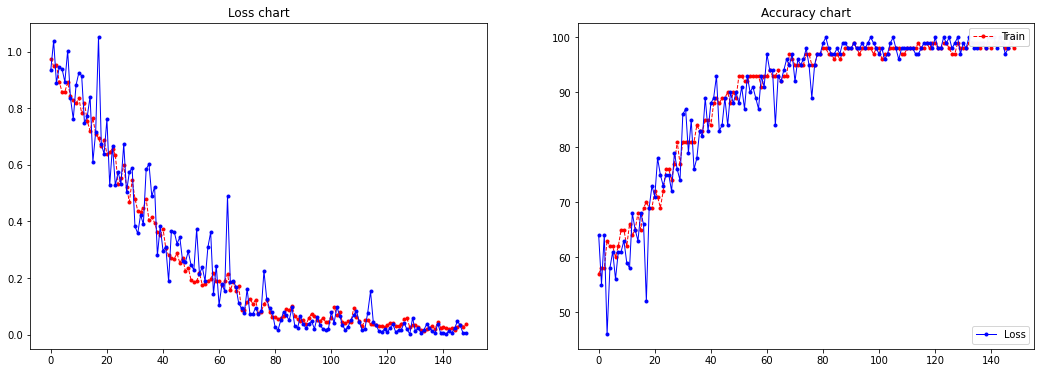

In [39]:
x = range(epochs)
# plt.figure(figsize=(16, 4))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 6),)
line1, = ax1.plot(t_loss[1:], marker='.', label="Train", linestyle='--',linewidth=1,color="red")
line2, = ax1.plot(v_loss[1:],  marker='.' ,label="Loss", linewidth=1,color="blue")
ax1.set_title("Loss chart")
# Create a legend for the first line.
first_legend = plt.legend(handles=[line1], loc=1)
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)
# Create another legend for the second line.
plt.legend(handles=[line2], loc=4)

line3, = ax2.plot(t_acc[1:], marker='.', label="Train", linestyle='--',linewidth=1,color="red")
line4, = ax2.plot(v_acc[1:],  marker='.' ,label="Loss", linewidth=1,color="blue")
ax2.set_title("Accuracy chart")
# Create a legend for the first line in the second chart.
third_legend = plt.legend(handles=[line3], loc=1)
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(third_legend)
# Create another legend for the second line.
plt.legend(handles=[line4], loc=4)

plt.show()

try

In [115]:
# aww_data_path ='/content/drive/MyDrive/Colab Notebooks/Project 1-CV/Datasets/testing'

In [121]:
# aww_data = torchvision.datasets.ImageFolder(root = aww_data_path, transform = testing_transform)

In [117]:
# data_loader = torch.utils.data.DataLoader(dataset = aww_data,shuffle =False)

In [118]:
# print(len(data_loader))

380


In [119]:
# test_img_list = []
# for dir1 in os.listdir(test_data_path):
#     test_img_list.append(dir1)
# to_correct =0
# total_labels =[]
# model.eval()
# with torch.no_grad():
#         for bi, data in tqdm.tqdm(enumerate(data_loader), total = len(data_loader)):
#             images = data[0].to(device)
#             out = model(images)
#             ret, predictions = torch.max(out.data, 1)
#             # calculate total accuracy
#             total_labels.append(predictions[-1].tolist()+1)

# Test_results = pd.DataFrame(list(zip(test_img_list,total_labels)))
# Test_results.to_csv("CNN_test_try.csv",header=False,index=False)
# !cp CNN_test_try.csv "/content/drive/MyDrive/Colab Notebooks/Project 1-CV/Datasets"
# Test_results


100%|██████████| 380/380 [00:04<00:00, 92.82it/s]


,0,1
0,20200724_093940_LH_C1_PP_M.jpg,2
1,20200724_094015_RH_C2_PN_M.jpg,1
2,20200724_094108_RF_C1_PN_M.jpg,1
3,20200724_094015_LF_C2_PN_M.jpg,2
4,20200724_093935_RF_C2_PP_M.jpg,1
...,...,...
375,R9_0767_29_crop_LF_C2_PN_m.jpg,2
376,R9_0765_27_crop_LF_C2_PN_m.jpg,1
377,R8_0728_37_crop_LH_C2_PN_m.jpg,2
378,R7_0700_57_crop_RH_C3_PN_m.jpg,2


Testing data

In [69]:
testing_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.RandomRotation(20),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [122]:
predictions_list = []
test_img_list = []
test_labels = []
# test data

for dir1 in os.listdir(test_data_path):
  # append image names
    test_img_list.append(dir1)
  # load dataset
    image_path= os.path.join(test_data_path, dir1)
    image= cv2.imread(image_path)
  # transform images
    image = transforms.ToPILImage()(image)
  # data transformer, resize data
    img = testing_transform(image)
  # data loader format
    img =torchvision.utils.make_grid(img)
    img = img.unsqueeze(0)
 # predict
    model.eval()
    with torch.no_grad():
      outputs = model(img.to(device))
      _, predicted = torch.max(outputs.data, 1)
  # load the result into test_labels list
      test_labels.append(predicted[-1].tolist()+1)


    # for idx, i in enumerate(outputs):
    #   arg = torch.argmax(i).tolist()
    #   arg += 1
    #   test_labels.append(arg)


    # ret, predictions = torch.max(out.data, 1)
    # predictions_list.append(predictions)
Test_results = pd.DataFrame(list(zip(test_img_list,test_labels)))
Test_results

,0,1
0,20200724_093940_LH_C1_PP_M.jpg,1
1,20200724_094015_RH_C2_PN_M.jpg,1
2,20200724_094108_RF_C1_PN_M.jpg,1
3,20200724_094015_LF_C2_PN_M.jpg,1
4,20200724_093935_RF_C2_PP_M.jpg,1
...,...,...
375,R9_0767_29_crop_LF_C2_PN_m.jpg,1
376,R9_0765_27_crop_LF_C2_PN_m.jpg,1
377,R8_0728_37_crop_LH_C2_PN_m.jpg,1
378,R7_0700_57_crop_RH_C3_PN_m.jpg,1


In [123]:
Test_results.to_csv("CNN_test_new3.csv",header=False,index=False)
!cp CNN_test_new3.csv "/content/drive/MyDrive/Colab Notebooks/Project 1-CV/Datasets"
# Test_results.to_csv(r"C:\Users\Jiuge\Downloads\Test_results_cnn3.csv", index=False,header=False)

# 3. Evaluate your model using the developed software


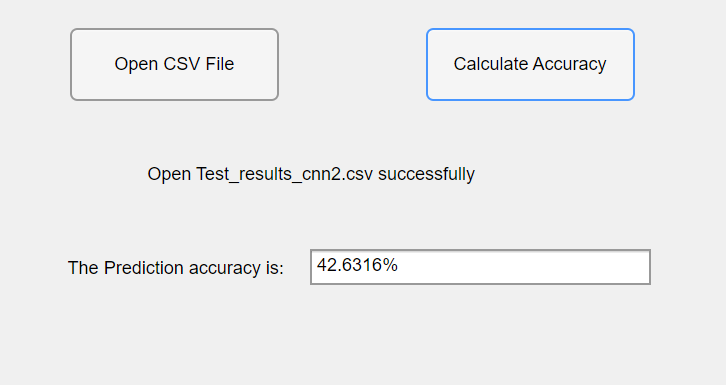

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.